<a href="https://colab.research.google.com/github/thientruc1691997/simulatedannealing/blob/main/SA_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive
drive.mount("/content/gdrive")
folder = '/content/gdrive/MyDrive/VB2/Tri tue nhan tao'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
import csv
import sys
import math
import random
import pandas as pd
import time

In [45]:
data = pd.read_csv(folder + '/vietnam.csv')

print(data.head())


    latitude   longitude            Name                     desc
0  20.865139  106.683830       Hai Phong        Haiphong, Vietnam
1   9.602521  105.973907       Soc Trang       Soc Trang, Vietnam
2  16.463713  107.590866  Thua Thien Hue  Thua Thien Hue, Vietnam
3  18.679585  105.681335         Nghe An   Vinh, Nghe An, Vietnam
4  16.047079  108.206230         Da Nang         Da Nang, Vietnam


In [ ]:
import matplotlib.pyplot as plt

No data
Improvement:                65 %
Time:                        0 sec
Initial distance:         8998 km
Optimal distance:         3188 km


<ipython-input-47-c80ec4006c42>:111: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend( (line_current, line_best, line_iteration)[:index_legend],


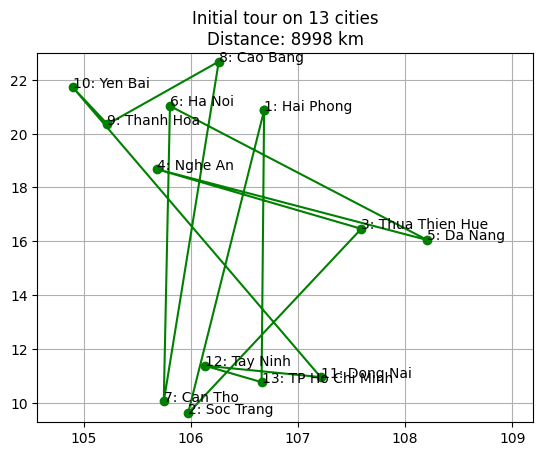

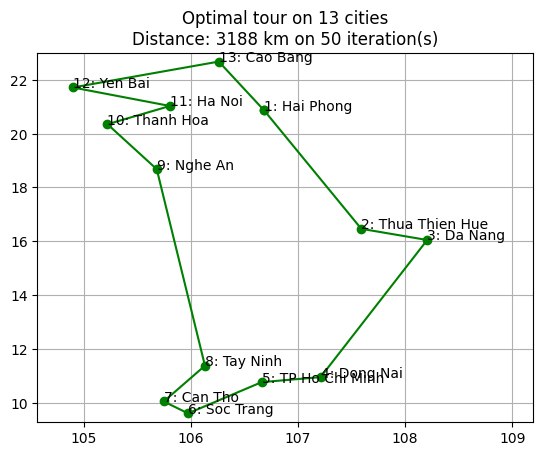

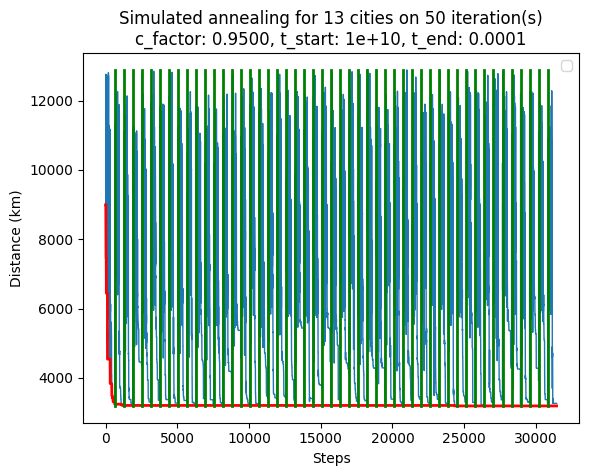

In [47]:
distances_pair = []


def read_cities(filename):
    reader =  csv.reader(open('/content/gdrive/MyDrive/VB2/Tri tue nhan tao/vietnam.csv', "r"))
    rows = [line for line in reader]
    cities = [City(r[2], index, r[3], float(r[0]), float(r[1])) for index, r in enumerate(rows[1:])]
    return cities

class City:
    def __init__(self, name='', index=0, description='', latitude=0, longitude=0):
        self.name = name
        self.description = description
        self.latitude = latitude
        self.longitude = longitude
        self.index = index

    def __str__(self):
        return '%s %d %s %f %f' % (self.name, self.index, self.description, self.latitude, self.longitude)

    def __repr__(self):
        return self.__str__()

    def compute_distance_to_city_in_km(self, city):
        #Sử dụng công thức hasrsine xác định khoảng cách đường tròn lớn giữa hai điểm trên một mặt cầu cho các kinh độ và vĩ độ
        lat = math.radians(self.latitude - city.latitude)
        long = math.radians(self.longitude - city.longitude)
        a = math.pow(math.sin(lat/2), 2) \
           + math.cos(math.radians(self.latitude)) * math.cos(math.radians(city.latitude)) * pow(math.sin(long/2), 2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        radius_earth = 6378.7 # in kilometers
        return radius_earth * c

    def distance_to_city_in_km(self, city):
        #Tính khoảng cách giữa 2 thành phố
        global distances_pair
        if self.index != city.index:
            indices = [self.index, city.index]
            return distances_pair[max(indices)][min(indices)]
        return 0


def compute_distance_pairs(cities):
    """
    Compute all distance pairs.
    /!\ IMPORTANT: The cities must be ordered by their indices in the list.
    """
    global distances_pair
    for city_from in cities:
        distances_pair.append([0 for r in range(city_from.index)]) # create
        for city_to in cities[:city_from.index]:
            distances_pair[city_from.index][city_to.index] = city_from.compute_distance_to_city_in_km(city_to)


def total_distance_in_km(cities):
    distances = [cities[index].distance_to_city_in_km(cities[(index + 1) % len(cities)]) for index in range(len(cities))]
    return sum(distances)


def plot_cities(cities, figure_id):
    """Plot the cities on a plan."""
    fig_map = plt.figure(figure_id)
    ax_map = fig_map.add_subplot(111)

    cities_x = [city.longitude for city in cities + [cities[0]]]
    cities_y = [city.latitude for city in cities + [cities[0]]]

    link = '-'
    ax_map.plot(cities_x, cities_y, 'go' + link)
    ax_map.grid()

    spacing = math.fabs(min(cities_x) - max(cities_x)) * .1
    ax_map.set_xlim(min(cities_x) - spacing, max(cities_x) + spacing * 3)
    ax_map.set_ylim(min(cities_y) - spacing, max(cities_y) + spacing)

    for index, city in enumerate(cities):
        ax_map.text(city.longitude,
                    city.latitude,
                    '%d: %s' % (index + 1, city.name),
                    #withdash = True,
                    #dashdirection = 1,
                    #dashlength = 30,
                    rotation = 0)
                    #dashrotation = 15,
                    #dashpush = 10
    return ax_map


def plot_distances(distances_current, figure_id, distances_best, ids_iteration, nb_cities, nb_iterations, cooling_factor, temperature_start, temperature_end):
    """Plot the evolution of the distance metrics."""
    # plot distances
    fig_distances = plt.figure(figure_id)
    ax_distances = fig_distances.add_subplot(111)
    line_current = ax_distances.plot(distances_current, linewidth=1)
    line_best = ax_distances.plot(distances_best, 'r', linewidth=2)
    ax_distances.set_title('Simulated annealing for %d cities on %d iteration(s)\nc_factor: %.4f, t_start: %g, t_end: %.4f' % (nb_cities, nb_iterations, cooling_factor, temperature_start, temperature_end))

    # plot iteration steps
    y_min = min(distances_current)
    y_max = max(distances_current)
    line_iteration = None

    for step in ids_iteration[:-1]:
        line_iteration = ax_distances.plot([step, step], [y_min, y_max], 'g', linewidth=2)

    ax_distances.set_xlabel('Steps')
    ax_distances.set_ylabel('Distance (km)')

    index_legend = 3 if len(ids_iteration) > 1 else 2
    plt.legend( (line_current, line_best, line_iteration)[:index_legend],
                ('Tested distance', 'Shortest distance', 'Restart')[:index_legend],
                loc='upper right' )


def compute_swap_indices(index, nb_cities):
    index_previous = (index - 1 + nb_cities) % nb_cities
    index_next = (index + 1) % nb_cities
    return (index_previous, index_next)


def distance_swap(cities, index_a, index_b):
    """Compute the distance inferred by the two given indices."""
    index_A = min(index_a, index_b)
    index_B = max(index_a, index_b)

    (index_A_previous, index_A_next) = compute_swap_indices(index_A, len(cities))
    (index_B_previous, index_B_next) = compute_swap_indices(index_B, len(cities))

    distances = []
    # These two distances are common to the two sub-cases
    distances.append(cities[index_A_previous].distance_to_city_in_km(cities[index_A]))
    distances.append(cities[index_B].distance_to_city_in_km(cities[index_B_next]))
    if index_A == index_B_previous:
        distances.append(cities[index_A].distance_to_city_in_km(cities[index_B]))
    else:
        distances.append(cities[index_A].distance_to_city_in_km(cities[index_A_next]))
        distances.append(cities[index_B_previous].distance_to_city_in_km(cities[index_B]))

    return sum(distances)


def annealing(cities, temperature_begin=1.0e+10, temperature_end=.0001, cooling_factor=.95, nb_iterations=10):

    #distance_best:    best solution encountered so far
    #distance_current: solution used in the current simulation
    #distance_new:     solution computed from the random changes to current


    cities_best = cities[:]
    distance_best = total_distance_in_km(cities_best)

    distances_current = []
    distances_best = []
    ids_iteration = []

    try:
        for iteration in range(nb_iterations):
            # the search is restarted at every iteration from
            # the best know solution
            temperature = temperature_begin
            cities_current = cities_best[:]
            distance_current = distance_best
            distance_new = distance_best
            cities_new = cities_best[:]

            step = 0
            while temperature > temperature_end:
                # compute the indices of the two cities to swap by random,
                # but never touch the first city (it does not need to change)
                index = random.sample(range(len(cities_new) - 1), 2)
                index[0] += 1
                index[1] += 1

                # optimize by recomputing only the changed distances
                swap_before = distance_swap(cities_new, index[0], index[1])
                cities_new[index[0]], cities_new[index[1]] = cities_new[index[1]], cities_new[index[0]]
                swap_after = distance_swap(cities_new, index[0], index[1])

                # compute the new distance
                # recomputing all is bad: distance_new = total_distance_in_km(cities_new)
                distance_new = distance_new - swap_before + swap_after

                # acceptance probability by Kirkpatrick et al.
                diff = distance_new - distance_current
                if diff < 0 or  math.exp( -diff / temperature ) > random.random():
                    cities_current = cities_new[:]
                    distance_current = distance_new
                else:
                    # reset cities and distance
                    distance_new = distance_current
                    cities_new = cities_current[:]

                # update the best if current solution is better
                # not part of the annealing itself, just used for the restart
                if distance_current < distance_best:
                    cities_best = cities_current[:]
                    distance_best = distance_current

                if True:

                    distances_current.append(distance_current)
                    distances_best.append(distance_best)
                temperature = temperature * cooling_factor
                step = step + 1
            ids_iteration.append(len(distances_current))
    except Exception or KeyboardInterrupt:
        print ("Interrupted on user demand.")
        print ('performed iterations: %d' % iteration )

    return cities_best, distances_current, distances_best, ids_iteration


def display_usage():
    print ('usage: %s input [plot] [nb_ite] [nb_cities] [c_factor] [t_start] [t_end] [r_seed]' % sys.argv[0])
    print ('  input: input CSV file containing the city coordinates')
    print ('  output: \'plot\' to display figures to screen, \'file\' to save')
    print ('          figures to files (default: \'plot\')')
    print ('  nb_ite: number of iterations in the restart process (default: 1)')
    print ('  nb_cities: number of cities read from the input file (n first lines,')
    print ('             default: all cities in file)')
    print ('  c_factor: cooling factor, float number in (0,1) (default: .95)')
    print ('  t_start: initial temperature (default: 1.0e+50, maximum: 1.0e+300)')
    print ('  t_end: temperature at which the process will be stopped (default: .1)')
    print ('         must be smaller than t_start')
    print (  'r_seed: seed for the random number generator (default: standard')
    print ('          \'library\'s default)')


if __name__ == '__main__':

    if len(sys.argv) < 2:
        display_usage()
        sys.exit(0)

    input             = sys.argv[1]
    plot              = sys.argv[2]        if len(sys.argv) > 2 else 'plot'
    nb_iterations     = int(sys.argv[3])   if len(sys.argv) > 3 else 50
    nb_cities         = int(sys.argv[4])   if len(sys.argv) > 4 else -1
    cooling_factor    = float(sys.argv[5]) if len(sys.argv) > 5 else .95
    temperature_start = float(sys.argv[6]) if len(sys.argv) > 6 else 1.0e+10
    temperature_end   = float(sys.argv[7]) if len(sys.argv) > 7 else .0001
    random_seed       = float(sys.argv[8]) if len(sys.argv) > 8 else -1

    if random_seed == -1:
        random.seed()
    else:
        random.seed(random_seed)

    time_begin = time.time()
    cities = read_cities(input)
    compute_distance_pairs(cities)

    nb_cities = len(cities) if nb_cities <= 0 else nb_cities

    print ('No data')

    cities = cities[:nb_cities]
    (cities_new, distances_current, distances_best, ids_iteration) = annealing(cities, temperature_start, temperature_end, cooling_factor, nb_iterations)
    time_end = time.time()

    distance_begin = total_distance_in_km(cities)
    distance_end = total_distance_in_km(cities_new)
    print ('Improvement:          %8.0f %%'  % (100 * (distance_begin - distance_end) / distance_begin))
    print ('Time:                 %8.0f sec' % (time_end - time_begin))
    print ('Initial distance:     %8.0f km'  % distance_begin)
    print ('Optimal distance:     %8.0f km'  % distance_end)

    ax_map = plot_cities(cities, 1)
    ax_map.set_title('Initial tour on %d cities\nDistance: %.0f km' % (len(cities), distance_begin))



    if nb_iterations:
        ax_map = plot_cities(cities_new, 2)
        ax_map.set_title('Optimal tour on %d cities\nDistance: %.0f km on %d iteration(s)' % (len(cities), distance_end, nb_iterations))
        plot_distances(distances_current, 3, distances_best, ids_iteration, len(cities), nb_iterations, cooling_factor, temperature_start, temperature_end)


    if plot == 'plot':
        plt.show()
    else:
        # save in files
        format = 'png'

        parameters = { 'nb_cities': len(cities),
                       'nb_ite': nb_iterations,
                       'c_factor': cooling_factor,
                       't_start': temperature_start,
                       't_end': temperature_end,
                       'format': format
                      }

        plt.figure(1,figsize=(800, 500))
        plt.savefig('tsp_cities_c%(nb_cities)d_init_f%(c_factor).4f_s%(t_start)g_e%(t_end).4f.%(format)s' % parameters, format=format)
        plt.figure(2,figsize=(800, 500))
        plt.savefig('tsp_cities_c%(nb_cities)d_i%(nb_ite)d_f%(c_factor).4f_s%(t_start)g_e%(t_end).4f.%(format)s' % parameters, format=format)
        #plt.figure(3)
        plt.figure(3, figsize=(800, 500))
        plt.savefig('tsp_distances_c%(nb_cities)d_i%(nb_ite)d_f%(c_factor).4f_s%(t_start)g_e%(t_end).4f.%(format)s' % parameters, format=format)